In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 6

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
# print(X_dataset.shape)
# print(y_dataset.shape)
# print(X_dataset)
# print(y_dataset)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),     #number of additional para
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 40)                1720      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 6)                 126       
                                                                 
Total params: 2666 (10.41 KB)
Trainable params: 2666 (10.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
history=model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
34/42 [=======================>......] - ETA: 0s - loss: 1.8121 - accuracy: 0.1721 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
42/42 [==============================] - 1s 8ms/step - loss: 1.7963 - accuracy: 0.1856 - val_loss: 1.6570 - val_accuracy: 0.3906
Epoch 2/1000
35/42 [========================>.....] - ETA: 0s - loss: 1.6553 - accuracy: 0.3002
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
42/42 [==============================] - 0s 2ms/step - loss: 1.6495 - accuracy: 0.3016 - val_loss: 1.5283 - val_accuracy: 0.4643
Epoch 3/1000
 1/42 [..............................] - ETA: 0s - loss: 1.5984 - accuracy: 0.3672
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
42/42 [==============================] - 0s 2ms/step - loss: 1.5502 - accuracy: 0.3608 - val_loss: 1.3872 - val_accuracy: 0.5146
Epoch 4/1000
 1/42 [..............................] - ETA: 0s - loss: 1.5411 - accuracy: 0.32

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

14/14 [==============================] - 0s 1ms/step - loss: 0.2138 - accuracy: 0.9669


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 79ms/step
[1.3148154e-01 2.1557726e-02 5.0483245e-06 8.4452760e-01 2.2060883e-03
 2.2203404e-04]
3


# Confusion matrix

55/55 [==============================] - 0s 759us/step


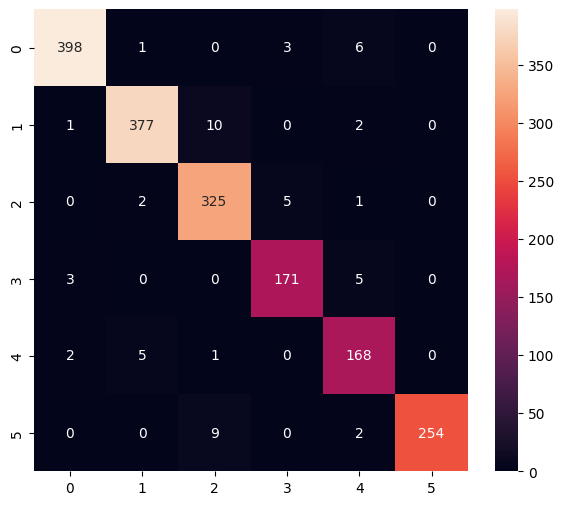

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       408
           1       0.98      0.97      0.97       390
           2       0.94      0.98      0.96       333
           3       0.96      0.96      0.96       179
           4       0.91      0.95      0.93       176
           5       1.00      0.96      0.98       265

    accuracy                           0.97      1751
   macro avg       0.96      0.96      0.96      1751
weighted avg       0.97      0.97      0.97      1751



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

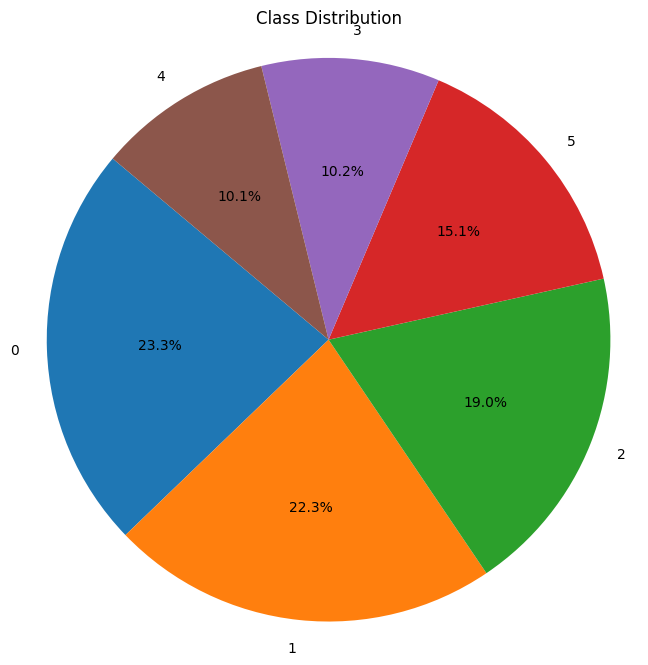

In [16]:
class_counts = pd.Series(y_test).value_counts()

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Class Distribution')


plt.savefig('ClassDistribution.png')

plt.show()

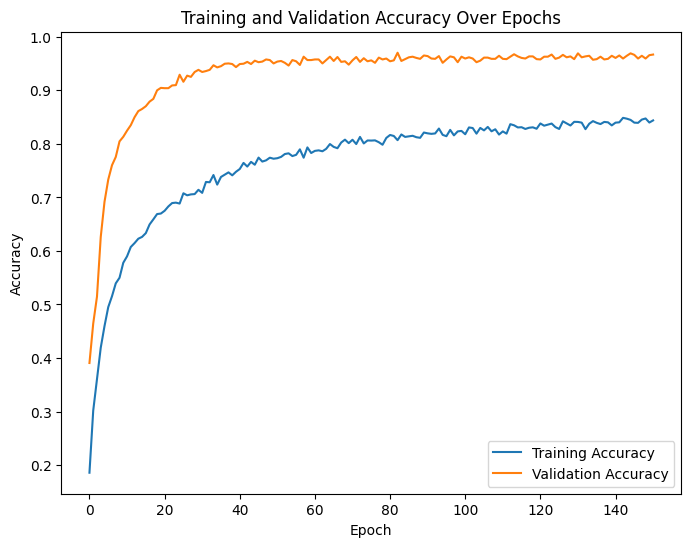

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()


plt.savefig('TrainingAccuracy.png')

plt.show()

# Convert to model for Tensorflow-Lite

In [18]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [19]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\samra\AppData\Local\Temp\tmpi_opfqp0\assets


INFO:tensorflow:Assets written to: C:\Users\samra\AppData\Local\Temp\tmpi_opfqp0\assets


7816

# Inference test

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [21]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.3316748e-01 2.2073006e-02 5.4059542e-06 8.4218186e-01 2.3478232e-03
 2.2443983e-04]
3
